In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
from scipy.stats import t

## Q1.

##### (a)
This model satisfies the assumptions of classical OLS model and asymptotic OLS model. \
The classcial OLS model is appropriate in this case. \
The beta_hat is unbiased, consistent, and it follows normal distribution. \
The theoretical standard error of beta_hat = 1/sqrt(T)

##### (b)

In [2]:
def ols(y, X, White=True, intercept=True, var_names=None):
    if type(y) != np.ndarray:
        y = y.to_numpy().reshape(-1, 1)
    if type(X) != np.ndarray:
        X = X.to_numpy().reshape(-1, 1) if len(X.shape) == 1 else X.to_numpy()
    n = X.shape[0]
    const = False
    for i in range(X.shape[1]):
        if np.array_equal(X[:,i], np.ones(n)):
            const = True     
    k = X.shape[1] + 1 if not const and intercept else X.shape[1]
    df_model = X.shape[1]-1 if const else X.shape[1]
    df_resid = n-k
    X = np.column_stack((np.ones(n), X)) if not const and intercept else X
    if var_names:
        names_x = var_names
    else:
        if const or intercept:
            names_x = ["intercept"]+["x"+str(i) for i in range(1,k)]
        else:
            names_x = ["x"+str(i) for i in range(1,k+1)]
    
    beta = np.linalg.inv(X.T@X)@(X.T@y)
    y_fitted = X@beta
    e = np.reshape((y - y_fitted), (-1, 1))
    sigma_squared = (1/(n-k))*np.sum(np.square(e))
    ols_var_cov_beta = np.linalg.inv(X.T@X) * sigma_squared
    ols_se = np.sqrt(np.diag(ols_var_cov_beta))
    White_var_cov_beta = (n/(n-k))*np.linalg.inv(X.T@X)@X.T@np.diag(np.diag(e@e.T))@X@np.linalg.inv(X.T@X)
    White_se = np.sqrt(np.diag(White_var_cov_beta))
    se = White_se if White else ols_se
    se = se.reshape(-1, 1)
    R_squared = 1 - np.sum(np.square(e))/np.sum(np.square(y-np.average(y)))
    adjusted_R_squared = 1 - (1-R_squared)*(n-1)/(n-k-1)
    max_log_likelihood = (-n/2)*(math.log(2*math.pi)+1)-(n/2)*math.log((1/n)*np.sum(np.square(e)))
    P = X@np.linalg.inv(X.T@X)@X.T
    M = np.identity(n) - P
    PM = P@M
    PM_equal_0 = np.all(PM<pow(10, -10))
    E_ex = X.T@e
    E_ex_equal_0 = np.all(E_ex<pow(10, -10))
    Q = np.zeros((k,k))
    for i in range(n):
        Q += X[i,:].reshape(1,-1).T@X[i,:].reshape(1,-1)
    Q = Q/n
    cond_Q = np.linalg.cond(Q)
    cond_X = np.linalg.cond(X)
    results = {"Number of parameters": k,
               "Names of parameters": names_x,
               "Sample size": n,
               "Degrees of freedom for residuals": df_resid,
               "Degrees of freedom for model": df_model,
               "y": y,
               "X": X,
               "Fitted y": y_fitted,
               "Residuals": e,
               "Beta": beta,
               "OLS standard errors": ols_se,
               "White standard errors": White_se,
               "OLS variance-covariance matrix": ols_var_cov_beta,
               "White variance-covariance matrix": White_var_cov_beta,
               "Standard errors": se,
               "Maximized log-likelihood function": max_log_likelihood,
               "R squared": R_squared,
               "Adjusted R squared": adjusted_R_squared,
               "PM = 0": PM_equal_0,
               "E(ex) = 0": E_ex_equal_0,
               "Conditional number for Q": cond_Q,
               "Conditional number for X": cond_X}
    return results

In [3]:
def t_test(ols_results, b):
    b = np.array(b).reshape(-1, 1)
    t_test = (ols_results["Beta"] - b)/ols_results["Standard errors"]
    alpha_list = [0.01, 0.05, 0.1]
    p_value = [t.sf(abs(t_i.item(0)), ols_results["Degrees of freedom for residuals"])*2 for t_i in t_test]
    boolList = [["Rejected" if p < alpha else "Not rejected" for p in p_value] for alpha in alpha_list]
    test_results = {k: v for (k,v) in zip(alpha_list, boolList)}
    results = {"Null hypothesis": b, "T-statistics": t_test, "P-values": p_value, "Test results": test_results}
    return results

In [4]:
def print_ols_results(ols_results):
    subset_dict = {k: ols_results[k] for k in ["Number of parameters",
                                               "Degrees of freedom for residuals",
                                               "Degrees of freedom for model",
                                               "Maximized log-likelihood function",
                                               "R squared",
                                               "Adjusted R squared",
                                               "PM = 0",
                                               "E(ex) = 0",
                                               "Conditional number for Q",
                                               "Conditional number for X"]}
    df1 = pd.DataFrame(subset_dict.items(), columns=["Name", "Value"])
    df1 = df1.round(3)
    ols_dict = {k: ols_results[k] for k in ["Names of parameters", "Beta",
                                            "OLS standard errors", "White standard errors"]}
    df2 = pd.DataFrame(data={"Indepent Variable": ols_dict["Names of parameters"],
                             "Coefficient": ols_dict["Beta"].flatten(),
                             "OLS standard errors": ols_dict["OLS standard errors"],
                             "White standard errors": ols_dict["White standard errors"]})
    df2 = df2.round(3)
    display(df1)
    display(df2)
    
def print_t_test_results(t_results, ols_results):
    data = {"Null hypothesis": t_results["Null hypothesis"].flatten(),
            "Indepent Variable": ols_results["Names of parameters"],
            "T-statistics": t_results["T-statistics"].flatten(),
            "P-values": t_results["P-values"]}
    combined_data = {**data, **t_results["Test results"]}
    df = pd.DataFrame(combined_data)
    df = df.round(3)
    display(df)

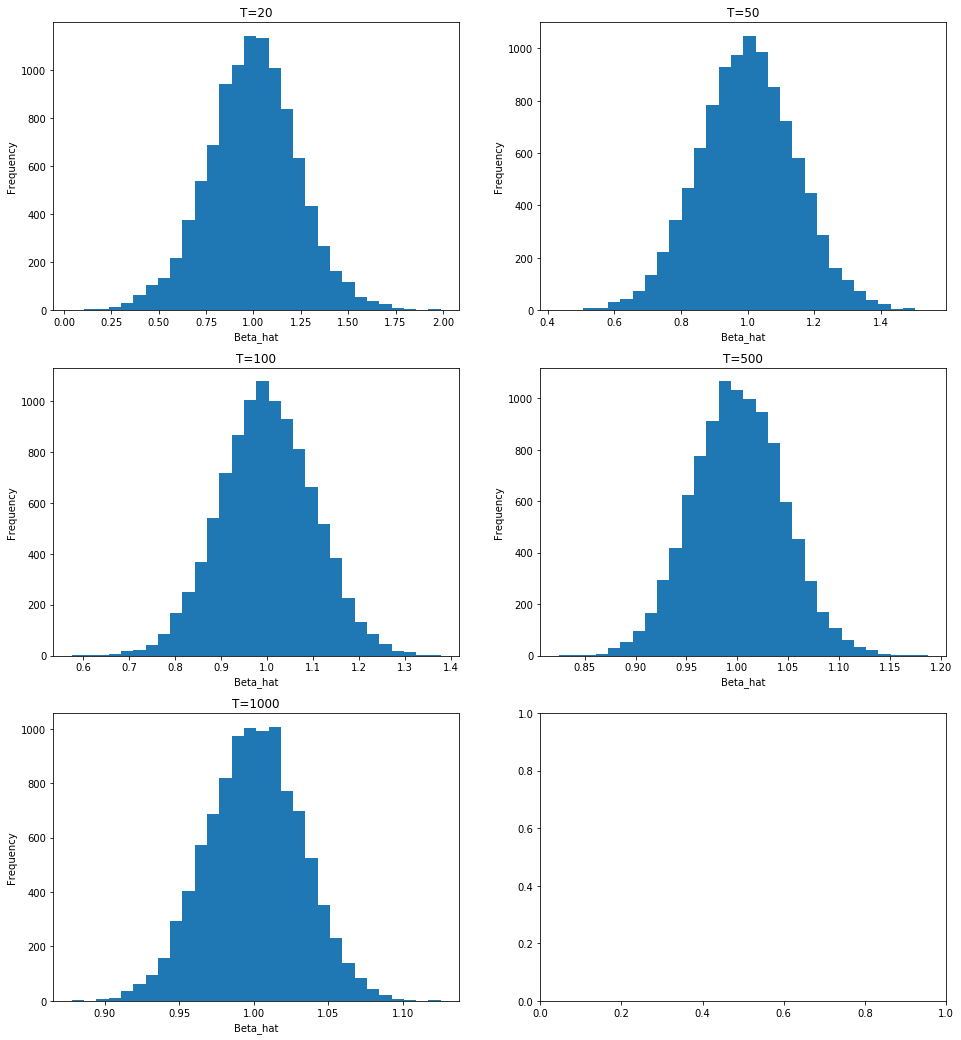

In [5]:
T_list = [20, 50, 100, 500, 1000]
fig, axs = plt.subplots(3,2,figsize=(16,18))
axs = axs.ravel()
for n, T in enumerate(T_list):
    beta_list = []
    for i in range(10000):
        x = np.random.normal(size = T).reshape(-1,1)
        e = np.random.normal(size = T).reshape(-1,1)
        y = x + e
        ols_results = ols(y, x, intercept=False)
        beta_list.append(ols_results["Beta"].item(0))
    axs[n].hist(beta_list, bins=30)
    axs[n].set_xlabel("Beta_hat")
    axs[n].set_ylabel("Frequency")
    axs[n].set_title("T=" + str(T))

Theoretically, the beta_hat follows a normal distribution with mean 1 and variance (X'X)^(-1). The result showed that the actual distribution tallied with the theoretical distribution.

## Q2.

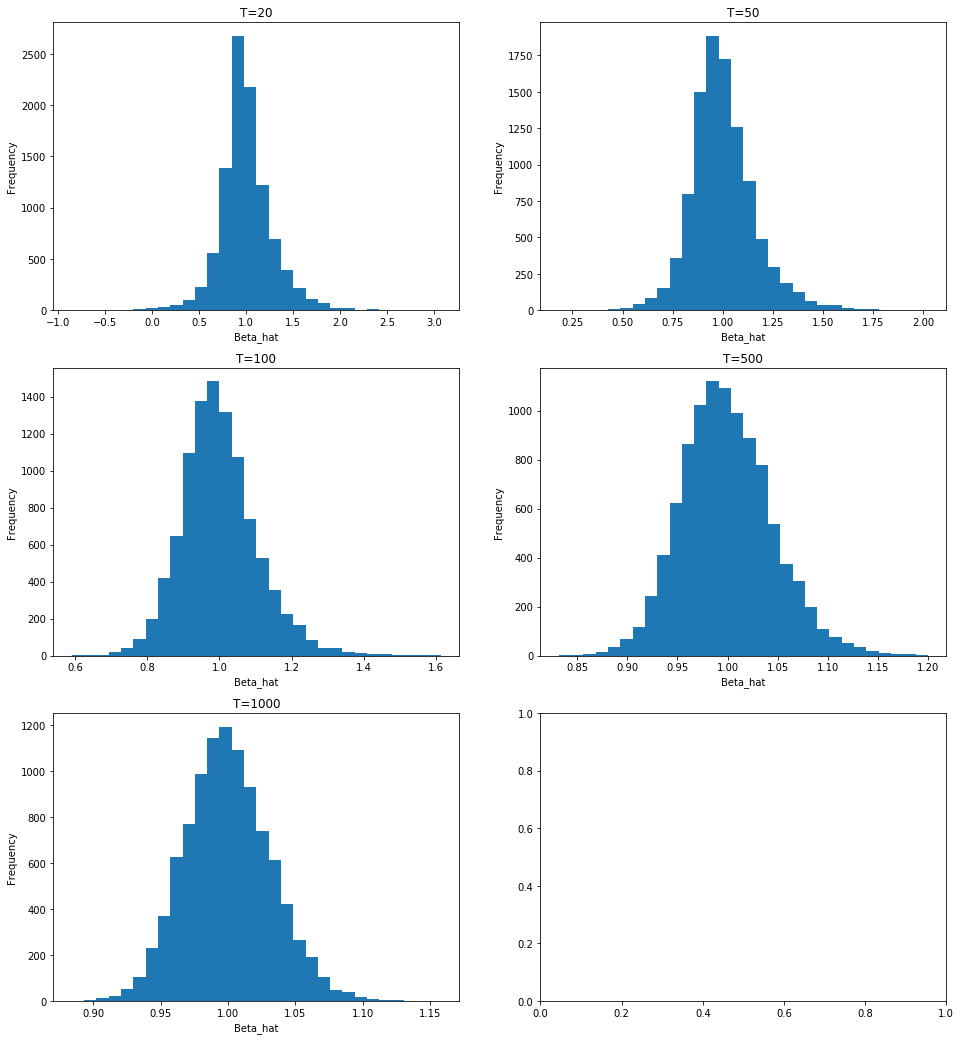

In [6]:
T_list = [20, 50, 100, 500, 1000]
fig, axs = plt.subplots(3,2,figsize=(16,18))
axs = axs.ravel()
for n, T in enumerate(T_list):
    beta_list = []
    for i in range(10000):
        x = (np.random.chisquare(df=1, size=T)-1).reshape(-1,1)
        e = (np.random.chisquare(df=1, size=T)-1).reshape(-1,1)
        y = x + e
        ols_results = ols(y, x, intercept=False)
        beta_list.append(ols_results["Beta"].item(0))
    axs[n].hist(beta_list, bins=30)
    axs[n].set_xlabel("Beta_hat")
    axs[n].set_ylabel("Frequency")
    axs[n].set_title("T=" + str(T))

The reason why we added 1 to x and e was to make the mean value of x and e equalling to 0.
Given that the errors followed the chi-square distribution instead of the normal distribution, the beta_hat did not follow the normal distribution as well. Indeed, based on the result, we can see that the distribution was slightly right-skewed.

## Q3

##### (a)

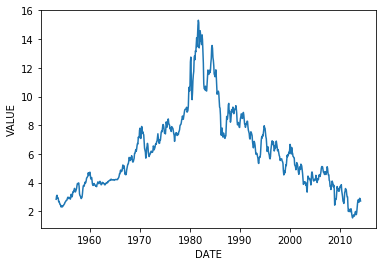

In [7]:
df = pd.read_excel("Tbill10yr.xls", skiprows=range(0,13),header=1)
sns.lineplot(x="DATE", y="VALUE", data=df)

#### (b)

In [8]:
def IC(ols_results):
    k = ols_results["Number of parameters"]
    n = ols_results["Sample size"]
    e = ols_results["Residuals"]
    ssr = np.sum(np.square(e))
    llf = -(n/2)*(np.log(2*np.pi)+1) - (n/2)*np.log(ssr/n)
    AIC = -2*llf/n + 2*k/n
    BIC = -2*llf/n + 2*k*np.log(n)/n
    HQIC = -2*llf/n + 2*k*np.log(np.log(n))/n
    results = {"AIC": AIC, "BIC": BIC, "Hannah-Quinn IC": HQIC}
    return results

In [9]:
def ACF(data, nlags):
    ACF_list = []
    for lag in range(nlags+1):
        data_lag = data.shift(periods=lag)
        mean = np.sum(data_lag[lag:])/(data_lag.shape[0]-lag)
        xt_demean = data - mean
        xt_lag_demean = data_lag - mean
        nom = np.sum(xt_demean*xt_lag_demean)
        denom = np.sum(xt_demean**2)
        ACF = nom/denom
        ACF_list.append(ACF)
    return np.asarray(ACF_list)

In [10]:
def PACF(data, nlags):
    '''OLS with constants to compute PACF'''
    PACF_list = []
    df_lags = data
    for lag in range(1, nlags+1):
        df_lag = data.shift(periods=lag)
        df_lag.name = "VALUE_LAG_{}".format(lag)
        df_lags = pd.concat([df_lags, df_lag], axis=1)
        
    for i in range(nlags+1):
        df_ilag = df_lags.iloc[:,:i+1]
        df_ilag = df_ilag.dropna()
        xt = df_ilag.iloc[:, 0]
        xt_mid_lags = df_ilag.iloc[:,1:-1]
        xt_last_lag = df_ilag.iloc[:, -1]
        ols_xt = ols(xt, xt_mid_lags, White=True)
        ols_xtli = ols(xt_last_lag, xt_mid_lags, intercept=True)
        ols_xt_e = ols_xt["Residuals"].flatten()
        ols_xtli_e = ols_xtli["Residuals"].flatten()
        PACF = np.corrcoef(ols_xt_e, ols_xtli_e).item((0,1))
        PACF_list.append(PACF)
        
    return np.asarray(PACF_list)

In [11]:
def plot_ACF_PACF(data, nlags):
    x = np.arange(0, nlags+1)
    ACF_result = ACF(data, nlags)
    PACF_result = PACF(data, nlags)
    fig, axs = plt.subplots(1,2,figsize=(16,6))
    axs[0].bar(x, ACF_result, width=0.08)
    axs[0].set_xlabel("Number of Lags")
    axs[0].set_ylabel("ACF")
    axs[1].bar(x, PACF_result, width=0.08)
    axs[1].plot([0, nlags], [0, 0], color="r", linewidth=0.5)
    axs[1].set_xlabel("Number of Lags")
    axs[1].set_ylabel("PACF")

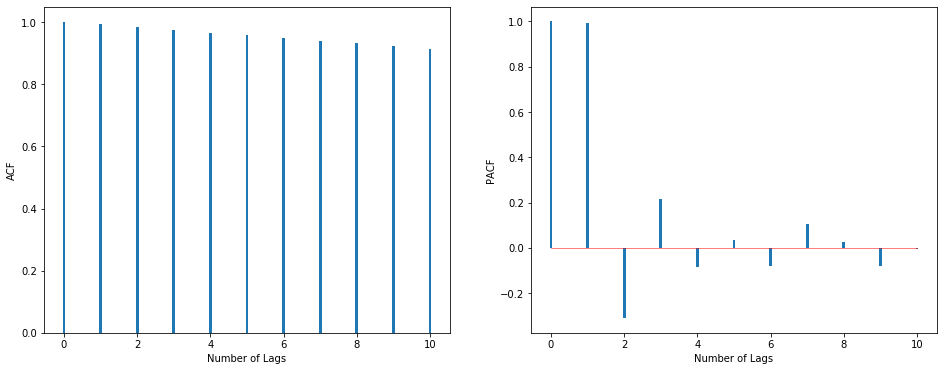

In [12]:
x = df["VALUE"]
plot_ACF_PACF(data=x, nlags=10)

Based on the ACF and PACF plots above, the process is likely to be a AR(1) process, but the PACF for 2nd and 3rd lag terms are still relatively lager than 0. Thus, we need further analysis to confirm.

#### (c)

In [13]:
x = df["VALUE"]
x_lag1 = x.shift(periods=1).dropna()
x_lag2 = x.shift(periods=2).dropna()
x_lag12 = pd.concat([x_lag1[1:], x_lag2], axis=1)
ols_AR1 = ols(x[1:], x_lag1, White=True, intercept=True, var_names=["mu", "Xt-1"])
ols_AR2 = ols(x[2:], x_lag12, White=True, intercept=True, var_names=["mu", "Xt-1", "Xt-2"])

#### (d)

In [14]:
print_ols_results(ols_AR1)
b_0 = [0, 0]
t_AR1 = t_test(ols_AR1, b_0)
print_t_test_results(t_AR1, ols_AR1)

,Name,Value
0,Number of parameters,2
1,Degrees of freedom for residuals,728
2,Degrees of freedom for model,1
3,Maximized log-likelihood function,-89.0811
4,R squared,0.990283
5,Adjusted R squared,0.990256
6,PM = 0,True
7,E(ex) = 0,True
8,Conditional number for Q,272.061
9,Conditional number for X,16.4943


,Indepent Variable,Coefficient,OLS standard errors,White standard errors
0,mu,0.029,0.024,0.032
1,Xt-1,0.995,0.004,0.006


,Null hypothesis,Indepent Variable,T-statistics,P-values,0.01,0.05,0.1
0,0,mu,0.908,0.364,Not rejected,Not rejected,Not rejected
1,0,Xt-1,162.840,0.000,Rejected,Rejected,Rejected


In [15]:
print_ols_results(ols_AR2)
b_0 = [0, 0, 0]
t_AR2 = t_test(ols_AR2, b_0)
print_t_test_results(t_AR2, ols_AR2)

,Name,Value
0,Number of parameters,3
1,Degrees of freedom for residuals,726
2,Degrees of freedom for model,2
3,Maximized log-likelihood function,-52.339
4,R squared,0.991209
5,Adjusted R squared,0.991173
6,PM = 0,True
7,E(ex) = 0,False
8,Conditional number for Q,2419.45
9,Conditional number for X,49.1879


,Indepent Variable,Coefficient,OLS standard errors,White standard errors
0,mu,0.037,0.023,0.031
1,Xt-1,1.304,0.035,0.055
2,Xt-2,-0.310,0.035,0.056


,Null hypothesis,Indepent Variable,T-statistics,P-values,0.01,0.05,0.1
0,0,mu,1.186,0.236,Not rejected,Not rejected,Not rejected
1,0,Xt-1,23.606,0.000,Rejected,Rejected,Rejected
2,0,Xt-2,-5.493,0.000,Rejected,Rejected,Rejected


#### (e)

For AR(1), the root is 1/phi1 = 1/0.995 = 1.005

In [16]:
L1 = (-(1.304/(-0.310))+np.sqrt((1.304/(-0.310))**2+4/(-0.310)))/2
L2 = (-(1.304/(-0.310))-np.sqrt((1.304/(-0.310))**2+4/(-0.310)))/2
print("L1:", L1)
print("L2:", L2)

L1: 3.1976445294781954
L2: 1.008807083425031


For AR(2), the roots are 3.1976 and 1.0088.

#### (f)

In [17]:
def IRF_AR1(phi, nlags):
    IRF_list = []
    for i in range(nlags+1):
        IRF = phi**i
        IRF_list.append(IRF)
    return np.asarray(IRF_list)

In [18]:
def IRF_AR2(phi1, phi2, nlags):
    q0 = 1
    q1 = phi1
    qim2 = q0
    qim1 = q1
    IRF_list = [q0, q1]
    for i in range(2, nlags+1):
        qi = qim2*phi2 + qim1*phi1
        qim2 = qim1
        qim1 = qi
        IRF_list.append(qi)
    return np.asarray(IRF_list)

In [19]:
def plot_IRF(IRF, nlags):
    fig, ax = plt.subplots()
    x = np.arange(0, nlags+1)
    ax.bar(x, IRF, width=0.08)
    ax.set_xlabel("Number of lags")
    ax.set_ylabel("IRF")

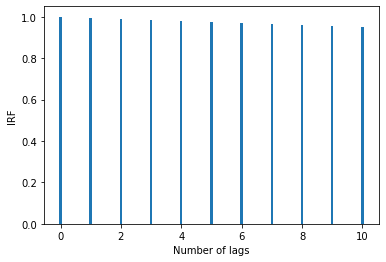

In [20]:
IRF1 = IRF_AR1(0.995, 10)
plot_IRF(IRF1, 10)

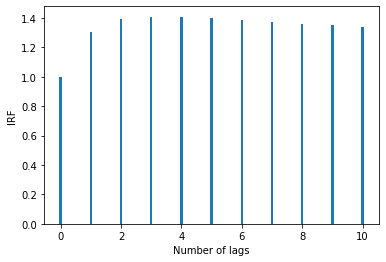

In [21]:
IRF2 = IRF_AR2(1.304, -0.31, 10)
plot_IRF(IRF2, 10)

##### (g)

Both models do not work well because of non-stationarity.

## Q4.

##### (a)

In [22]:
def ADF(data, nlags):
    '''Regression without constanta and trend'''
    delta_zt = data.diff(periods=1).dropna()
    zt_m1 = data.shift(periods=1).dropna()
    df = zt_m1
    for i in range(1, nlags+1):
        delta_zt_mi = delta_zt.shift(periods=i)
        df = pd.concat([df, delta_zt_mi], axis=1)
    df = df.dropna()
    ols_ADF = ols(delta_zt[nlags:], df, intercept=False, White=False)
    ADF = ols_ADF["Beta"].item(0)/ols_ADF["Standard errors"].item(0)
    return ADF

In [23]:
zt = df["VALUE"]
ADF_Tbill_1 = ADF(zt, 1)
ADF_Tbill_2 = ADF(zt, 2)
ADF_Tbill_3 = ADF(zt, 3)
ADF_Tbill_list = [ADF_Tbill_1, ADF_Tbill_2, ADF_Tbill_3]
p = [1,2,3]
ADF_Tbill_df = pd.DataFrame({"Number of Lags": p, "ADF Test": ADF_Tbill_list})
display(ADF_Tbill_df)

,Number of Lags,ADF Test
0,1,-0.777741
1,2,-0.625254
2,3,-0.665222


The critical value at a 5% significance level is -1.9414. Thus, we fail to reject the null hypothesis, and we conclude that T-bill data is non-stationary.

##### (b)

In [24]:
delta_zt = zt.diff(1).dropna()
ADF_dTbill_1 = ADF(delta_zt, 1)
ADF_dTbill_2 = ADF(delta_zt, 2)
ADF_dTbill_3 = ADF(delta_zt, 3)
ADF_dTbill_list = [ADF_dTbill_1, ADF_dTbill_2, ADF_dTbill_3]
p = [1,2,3]
ADF_dTbill_df = pd.DataFrame({"Number of Lags": p, "ADF Test": ADF_dTbill_list})
display(ADF_dTbill_df)

,Number of Lags,ADF Test
0,1,-19.788094
1,2,-14.688811
2,3,-13.346075


By taking first difference, the ADF test showed that delta_zt is stationary

##### (c)

In [25]:
IC_AR1 = IC(ols_AR1)
df_IC_AR1 = pd.DataFrame(data = IC_AR1.items(), columns=["IC Type", "Value"])
df_IC_AR1 = df_IC_AR1.round(4)
display(df_IC_AR1)

,IC Type,Value
0,AIC,0.2495
1,BIC,0.2802
2,Hannah-Quinn IC,0.2544


In [26]:
IC_AR2 = IC(ols_AR2)
df_IC_AR2 = pd.DataFrame(data = IC_AR2.items(), columns=["IC Type", "Value"])
df_IC_AR2 = df_IC_AR2.round(4)
display(df_IC_AR2)

,IC Type,Value
0,AIC,0.1518
1,BIC,0.1978
2,Hannah-Quinn IC,0.1591


In [27]:
x = df["VALUE"]
x_lag1 = x.shift(periods=1).dropna()
x_lag2 = x.shift(periods=2).dropna()
x_lag3 = x.shift(periods=3).dropna()
x_lag123 = pd.concat([x_lag1[2:], x_lag2[1:], x_lag3], axis=1)
ols_AR3 = ols(x[3:], x_lag123, White=True, intercept=True, var_names=["mu", "Xt-1", "Xt-2", "Xt-3"])
IC_AR3 = IC(ols_AR3)
df_IC_AR3 = pd.DataFrame(data = IC_AR3.items(), columns=["IC Type", "Value"])
df_IC_AR3 = df_IC_AR3.round(4)
print_ols_results(ols_AR3)
b_0 = [0, 0, 0, 0]
t_AR3 = t_test(ols_AR3, b_0)
print_t_test_results(t_AR3, ols_AR3)
display(df_IC_AR3)

,Name,Value
0,Number of parameters,4
1,Degrees of freedom for residuals,724
2,Degrees of freedom for model,3
3,Maximized log-likelihood function,-35.659
4,R squared,0.991599
5,Adjusted R squared,0.991553
6,PM = 0,True
7,E(ex) = 0,True
8,Conditional number for Q,7845.45
9,Conditional number for X,88.5746


,Indepent Variable,Coefficient,OLS standard errors,White standard errors
0,mu,0.029,0.023,0.030
1,Xt-1,1.370,0.036,0.059
2,Xt-2,-0.589,0.059,0.100
3,Xt-3,0.214,0.036,0.059


,Null hypothesis,Indepent Variable,T-statistics,P-values,0.01,0.05,0.1
0,0,mu,0.967,0.334,Not rejected,Not rejected,Not rejected
1,0,Xt-1,23.039,0.000,Rejected,Rejected,Rejected
2,0,Xt-2,-5.874,0.000,Rejected,Rejected,Rejected
3,0,Xt-3,3.621,0.000,Rejected,Rejected,Rejected


,IC Type,Value
0,AIC,0.1090
1,BIC,0.1704
2,Hannah-Quinn IC,0.1187


In [28]:
x_lag4 = x.shift(periods=4).dropna()
x_lag1234 = pd.concat([x_lag1[3:], x_lag2[2:], x_lag3[1:], x_lag4], axis=1)
ols_AR4 = ols(x[4:], x_lag1234, White=True, intercept=True, var_names=["mu", "Xt-1", "Xt-2", "Xt-3", "Xt-4"])
IC_AR4 = IC(ols_AR4)
df_IC_AR4 = pd.DataFrame(data = IC_AR4.items(), columns=["IC Type", "Value"])
df_IC_AR4 = df_IC_AR4.round(4)
print_ols_results(ols_AR4)
b_0 = [0, 0, 0, 0, 0]
t_AR4 = t_test(ols_AR4, b_0)
print_t_test_results(t_AR4, ols_AR4)
display(df_IC_AR4)

,Name,Value
0,Number of parameters,5
1,Degrees of freedom for residuals,722
2,Degrees of freedom for model,4
3,Maximized log-likelihood function,-33.3423
4,R squared,0.991648
5,Adjusted R squared,0.99159
6,PM = 0,True
7,E(ex) = 0,False
8,Conditional number for Q,16035.4
9,Conditional number for X,126.631


,Indepent Variable,Coefficient,OLS standard errors,White standard errors
0,mu,0.033,0.023,0.030
1,Xt-1,1.388,0.037,0.060
2,Xt-2,-0.638,0.062,0.101
3,Xt-3,0.328,0.062,0.091
4,Xt-4,-0.084,0.037,0.055


,Null hypothesis,Indepent Variable,T-statistics,P-values,0.01,0.05,0.1
0,0,mu,1.088,0.277,Not rejected,Not rejected,Not rejected
1,0,Xt-1,23.184,0.000,Rejected,Rejected,Rejected
2,0,Xt-2,-6.289,0.000,Rejected,Rejected,Rejected
3,0,Xt-3,3.601,0.000,Rejected,Rejected,Rejected
4,0,Xt-4,-1.509,0.132,Not rejected,Not rejected,Not rejected


,IC Type,Value
0,AIC,0.1055
1,BIC,0.1824
2,Hannah-Quinn IC,0.1177


Given that the values of ACI, BIC and HQIC, AR(3) is the "best" AR(p) model because the coefficients of all three lag terms are significant and overall the model has small AIC, BIC and HQIC values.

We also want to check whether the residuals are stationary in this AR(3) model.

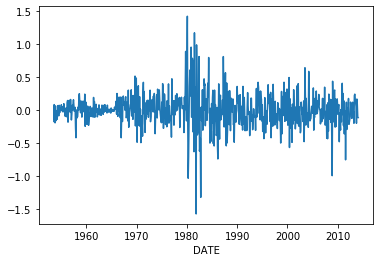

In [36]:
x = df["DATE"][3:]
y = ols_AR3["Residuals"].flatten()
sns.lineplot(x,y)


Based on the plot of the residuals in the AR(3) model, we can tell that the residuals are stationary. Although the variances varied accross different time periods, we can aply White correction or Newey-West correction to the model for heteroskedasticity.

##### (d)

Based on IC values and the stationary test, I prefered ARIMA(2,1,0) model for the T-bill data. Firstly, the AR(3) model has a better fit. Secondly, the original data ~ I(1), and thus we need to take first difference.